# Importing necessary libraries

In [ ]:
import kagglehub
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from googletrans import Translator
from pyspark.sql.functions import col, create_map, lit
from pyspark.sql.functions import length, trim
from itertools import chain
from pyspark import SparkContext
from pyspark.sql.functions import length
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

# Importing dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("najzeko/steam-reviews-2021")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/najzeko/steam-reviews-2021/versions/1


In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Steam Reviews Analysis") \
    .getOrCreate()

# Path to the dataset folder
dataset_path = "/root/.cache/kagglehub/datasets/najzeko/steam-reviews-2021/versions/1"

# Identify the CSV file
file_path = f"{dataset_path}/steam_reviews.csv"

# Load the data into a PySpark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True, multiLine=True, escape='"')

# Show a sample of the data
df.show(5)
# "schinese" is "simple chinese", "tchinese" is "traditional chinese"

+---+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|_c0|app_id|            app_name|review_id|language|                            review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author.steamid|author.num_games_owned|author.num_reviews|author.playtime_forever|author.playtime_last_two_weeks|author.playtime_at_review|author.last_played|
+---+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-----

We tried translating every review to English but our machine could not process so much records. For this reason we decided to take a sample of the reviews (only those that are English). The number of those is around 9 million, which is considered to be Big Data.

In [ ]:
df.filter(df.language == "english").count()

9635437

In [ ]:
sample_df = df.filter(df.language == "english")

In [ ]:
sample_df = sample_df.withColumn("review_length", length("review")) #create new column with the length of each review

##  **Exploratory Data Analysis**

In [ ]:
#Rename the columns
from pyspark.sql.functions import col

# Rename each column manually
sample_df = sample_df.withColumnRenamed("author.steamid", "author_steamid") \
                     .withColumnRenamed("author.num_games_owned", "author_num_games_owned") \
                     .withColumnRenamed("author.num_reviews", "author_num_reviews") \
                     .withColumnRenamed("author.playtime_forever", "author_playtime_forever") \
                     .withColumnRenamed("author.playtime_last_two_weeks", "author_playtime_last_two_weeks") \
                     .withColumnRenamed("author.playtime_at_review", "author_playtime_at_review") \
                     .withColumnRenamed("author.last_played", "author_last_played")

# Check the updated column names
print(sample_df.columns)

['_c0', 'app_id', 'app_name', 'review_id', 'language', 'review', 'timestamp_created', 'timestamp_updated', 'recommended', 'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'author_steamid', 'author_num_games_owned', 'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks', 'author_playtime_at_review', 'author_last_played', 'review_length']


In [ ]:
sample_df = sample_df.select("_c0","app_id","app_name","review_id","review","recommended","votes_helpful","steam_purchase","received_for_free","written_during_early_access","votes_helpful","author_steamid", "author_num_games_owned", "author_num_reviews", "author_playtime_forever", "author_playtime_at_review")

In [ ]:
sample_df.show(5)

+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+
|_c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|votes_helpful|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|
+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+
|  3|292030|The Witcher 3: Wi...| 85184605|One of the best R...|       true|            0|          true|            false|                      false|            0|7656119

In [ ]:
sample_df.select("author_playtime_at_review").describe().show()

+-------+-------------------------+
|summary|author_playtime_at_review|
+-------+-------------------------+
|  count|                  9623590|
|   mean|        9140.550526778468|
| stddev|       26469.392176559402|
|    min|                      1.0|
|    max|                3228103.0|
+-------+-------------------------+



In [ ]:
sample_df.select("author_playtime_forever").describe().show()

+-------+-----------------------+
|summary|author_playtime_forever|
+-------+-----------------------+
|  count|                9635435|
|   mean|     16350.428221870627|
| stddev|     40881.450936788984|
|    min|                    0.0|
|    max|              3744943.0|
+-------+-----------------------+



In [ ]:
# Create new columns for playtime categories
sample_df = sample_df.withColumn(
    "playtime_category",
    when(col("author_playtime_at_review") < 5000, "Low")
    .when((col("author_playtime_at_review") >= 5000) & (col("author_playtime_at_review") < 20000), "Medium")
    .otherwise("High")
)

sample_df = sample_df.withColumn(
    "playtime_forever_category",
    when(col("author_playtime_forever") < 5000, "Low")
    .when((col("author_playtime_forever") >= 5000) & (col("author_playtime_forever") < 20000), "Medium")
    .otherwise("High")
)

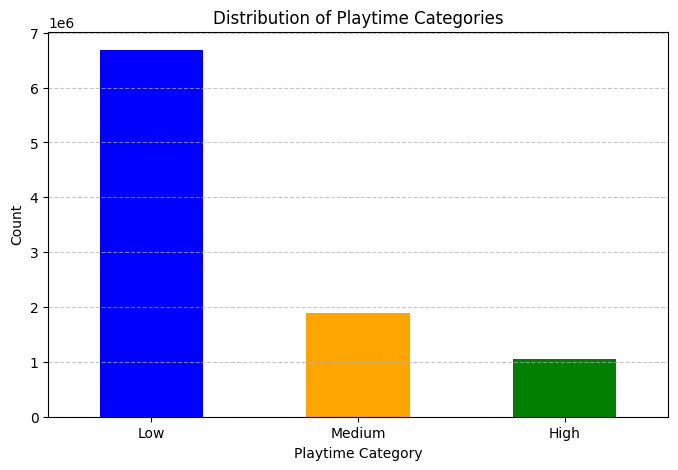

In [ ]:
# Convert PySpark DataFrame to Pandas
pandas_df = sample_df.select("playtime_category").toPandas()

# Count occurrences of each category
category_counts = pandas_df["playtime_category"].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color=["blue", "orange", "green"])
plt.title("Distribution of Playtime Categories")
plt.xlabel("Playtime Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

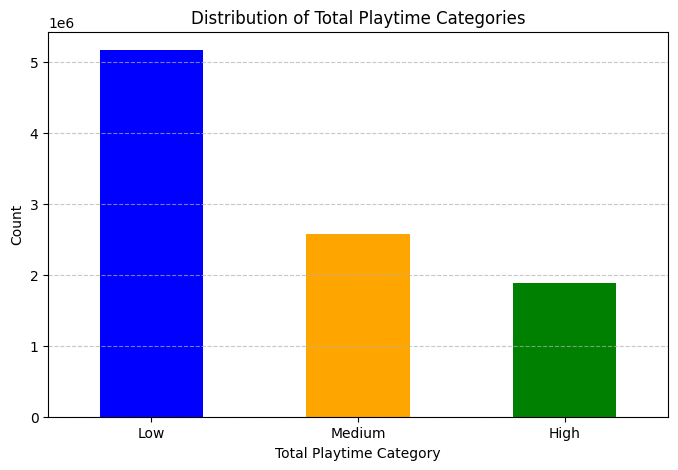

In [ ]:
# Convert PySpark DataFrame to Pandas
pandas_df = sample_df.select("playtime_forever_category").toPandas()

# Count occurrences of each category
category_counts_forever = pandas_df["playtime_forever_category"].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
category_counts_forever.plot(kind="bar", color=["blue", "orange", "green"])
plt.title("Distribution of Total Playtime Categories")
plt.xlabel("Total Playtime Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [ ]:
sample_df.select("app_name").distinct().show()

+--------------------+
|            app_name|
+--------------------+
|    Human: Fall Flat|
|DRAGON BALL FighterZ|
|The Elder Scrolls...|
|      Umbrella Corps|
|    Wallpaper Engine|
|          Nova Drift|
|           Detention|
|      SOULCALIBUR VI|
|The Witcher 3: Wi...|
|         GOD EATER 3|
|The Legend of Her...|
|     Thief Simulator|
|Ori and the Will ...|
|Danganronpa 2: Go...|
|       STEINS;GATE 0|
|        Just Cause 3|
|      NieR:Automata™|
|                 SOS|
| BattleBlock Theater|
|        For The King|
+--------------------+
only showing top 20 rows



In [ ]:
sample_df.select("app_name").distinct().count()

315

In [ ]:
sample_df.groupBy("app_id").count().show()

+-------+------+
| app_id| count|
+-------+------+
| 945360|295991|
| 238460| 24711|
| 477160| 24684|
| 285190|  9732|
|1180380|  2218|
| 704850|  3592|
| 357190|  1693|
|   4000|331621|
| 683320| 13520|
| 379720| 81046|
| 748490|  1160|
| 362890| 32851|
| 677120|  3351|
|1089980| 15158|
| 524220| 34564|
| 236510|  3031|
| 629760| 54515|
| 594650| 38954|
| 512900|  6970|
| 678950| 16864|
+-------+------+
only showing top 20 rows



In [ ]:
sample_df.groupBy("steam_purchase").count().show()

+--------------+-------+
|steam_purchase|  count|
+--------------+-------+
|          true|7443988|
|         false|2191449|
+--------------+-------+



In [ ]:
sample_df.groupBy("received_for_free").count().show()

+-----------------+-------+
|received_for_free|  count|
+-----------------+-------+
|             true| 279384|
|            false|9356053|
+-----------------+-------+



In [ ]:
sample_df.groupBy("written_during_early_access").count().show()

+---------------------------+-------+
|written_during_early_access|  count|
+---------------------------+-------+
|                       true| 959460|
|                      false|8675977|
+---------------------------+-------+



In [ ]:
sample_df.groupBy("votes_helpful").count().show()

+-------------+-----+
|votes_helpful|count|
+-------------+-----+
|           26| 2140|
|           29| 1722|
|          474|   11|
|         2214|    1|
|         2453|    1|
|           65|  449|
|         1277|    4|
|         1258|    1|
|          191|   72|
|          541|    8|
|         1010|    3|
|          418|   19|
|          558|    4|
|         2173|    1|
|         3199|    1|
|          293|   33|
|          270|   37|
|          222|   44|
|         1127|    3|
|          938|    6|
+-------------+-----+
only showing top 20 rows



In [ ]:
sample_df.groupBy("author_steamid").count().show()

+-----------------+-----+
|   author_steamid|count|
+-----------------+-----+
|76561198246061920|    4|
|76561198882961757|    5|
|76561198275504346|    7|
|76561198292152379|    3|
|76561198108626657|    4|
|76561198196390727|    3|
|76561198346006505|    1|
|76561199017986758|    1|
|76561197972712795|    2|
|76561198188685569|    7|
|76561199000227118|    2|
|76561198815886925|    1|
|76561198978750636|    2|
|76561198202624007|    4|
|76561198969165474|    4|
|76561198125844638|    4|
|76561198017020374|   13|
|76561198082328602|    1|
|76561198821635183|    1|
|76561198375448594|    4|
+-----------------+-----+
only showing top 20 rows



In [ ]:
sample_df.groupBy("author_num_games_owned").count().show()

+----------------------+-----+
|author_num_games_owned|count|
+----------------------+-----+
|                    26|65912|
|                    29|63475|
|                   474| 2339|
|                   964|  375|
|                  1950|   24|
|                  2040|   87|
|                  2927|   26|
|                  1806|   21|
|                  2214|   20|
|                  1677|  100|
|                  2250|   31|
|                  5385|    6|
|                  1697|   32|
|                  3091|   10|
|                  7279|    3|
|                  2453|   12|
|                  2529|    5|
|                  3764|    2|
|                  2509|    3|
|                  4590|    1|
+----------------------+-----+
only showing top 20 rows



In [ ]:
sample_df.groupBy("author_num_reviews").count().show()

+------------------+-----+
|author_num_reviews|count|
+------------------+-----+
|                29|37867|
|                26|45971|
|               474|   29|
|              3764|    3|
|                65| 6558|
|               191|  370|
|               418|    5|
|              1010|    1|
|               293|  182|
|               222|  130|
|               270|  102|
|               243|  232|
|               367|   31|
|               278|   20|
|                19|82042|
|                54| 9990|
|               296|   24|
|               348|   65|
|               287|   62|
|              1077|   15|
+------------------+-----+
only showing top 20 rows



In [ ]:
sample_df.groupBy("author_playtime_forever").count().show()

+-----------------------+-----+
|author_playtime_forever|count|
+-----------------------+-----+
|                  558.0| 1945|
|                11028.0|  172|
|                 1051.0| 1552|
|                 3597.0|  621|
|                 6454.0|  306|
|                 3980.0|  539|
|                  496.0| 2045|
|                  299.0| 2244|
|                13533.0|  129|
|                22797.0|   58|
|                10831.0|  180|
|                 4066.0|  533|
|                 5360.0|  427|
|                10129.0|  172|
|                 5776.0|  342|
|                11112.0|  171|
|                  769.0| 1858|
|                12172.0|  140|
|                14452.0|  120|
|                10024.0|  196|
+-----------------------+-----+
only showing top 20 rows



In [ ]:
sample_df.groupBy("author_playtime_at_review").count().show()

+-------------------------+-----+
|author_playtime_at_review|count|
+-------------------------+-----+
|                  52086.0|    9|
|                   6765.0|  221|
|                  11028.0|  121|
|                    305.0| 4569|
|                    496.0| 3220|
|                  10930.0|  124|
|                   3980.0|  451|
|                   2862.0|  715|
|                  22797.0|   35|
|                   5983.0|  275|
|                    692.0| 2871|
|                    299.0| 4613|
|                    934.0| 2253|
|                   4142.0|  503|
|                    558.0| 3053|
|                   5776.0|  283|
|                  11112.0|  130|
|                   3597.0|  530|
|                   1761.0| 1089|
|                  20689.0|   51|
+-------------------------+-----+
only showing top 20 rows



In [ ]:
sample_df.groupBy("received_for_free", "recommended").count().show()

+-----------------+-----------+-------+
|received_for_free|recommended|  count|
+-----------------+-----------+-------+
|             true|      false|  30930|
|             true|       true| 248454|
|            false|      false|1020063|
|            false|       true|8335990|
+-----------------+-----------+-------+



In [ ]:
sample_df.groupBy("app_name", "steam_purchase").count().show()

In [ ]:
sample_df.groupBy("app_name", "recommended").count().show()

In [ ]:
sample_df.groupBy("app_name", "received_for_free").count().show()

In [ ]:
sample_df.groupBy("app_name", "written_during_early_access").count().show()

In [ ]:
sample_df.groupBy("steam_purchase", "reccomended").count().show()

In [ ]:
sample_df.groupBy("author_steamid", "written_during_early_access").count().show()

In [ ]:
sample_df.groupBy("playtime_forever_category", "recommended").count().show()

In [ ]:
sample_df.groupBy("playtime_category", "recommended").count().show()

In [ ]:
sample_df.groupBy("written_during_early_access", "recommended").count().show()

In [ ]:
sample_df.groupBy("author_num_games_owned", "recommended").count().show()